## Do Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import pprint
from __future__ import division
from __future__ import print_function
from datetime import datetime
import matplotlib.pyplot as plt
import os
from fractions import Fraction 
import scipy.odr.odrpack as odrpack
import time
from bisect import bisect_left
import datetime as dt
import matplotlib.dates as mdates
import calendar
from sklearn import preprocessing

## Define functions for dataSet computation

In [2]:
def calcMathisModel_outMBitsPerSec(packetloss, MSS, RTT, C=np.sqrt(3/2)):
    '''
    Returns the result of mathis model in Bits/s.
    It does work with np.arrays.
    '''
    outVal = (MSS/RTT)*C/np.sqrt(packetloss)
    # convert inf vals to nan
    outVal = outVal*np.isfinite(outVal)
    return outVal


In [3]:
# smir out data
def smoothDataFrame(data, steps):
    # make sure that there are no nans! This would brick the cumsum function!
    # This may happen naturally when the packet_loss is at 1, so no packets get through
    # for simplicity we will drop those lines    
    data_smired = data.copy(deep=True)
    if "packet_loss" in data_smired.axes[1]:
        data_smired = data_smired.dropna(axis=0, subset=["delay_avg"])
    for col in data_smired.axes[1]:
        # do NOT smir our "throughput_perfSonar"
        if col == "throughput_perfSonar":
            continue
        vals = data_smired[col].values
        valsSumed = np.cumsum(vals)
        for i in range(steps, len(data_smired)):
            summ = valsSumed[i] - valsSumed[i-steps]
            vals[i] = summ/steps
        vals[:steps] = float('nan')
        data_smired[col] = vals
    # make sure not to use the first values, which were not averaged, e.g. delete them
    data_smired = data_smired.drop(data_smired.index[:steps])
    return data_smired

## Import raw data and compute dataset

In [4]:
# read our raw data
data_router = pd.read_pickle("raw_data_routers/raw_router_CERN_to_RAL-PIC-TRIUMF-KIT-IN2P3-BNL-CNAF-JINR-T1_highres.pkl")
data_perfSonar = pd.read_pickle("raw_data_routers/raw_toolkit_CERN_to_RAL-PIC-TRIUMF-KIT-IN2P3-BNL-CNAF-JINR-T1_sorted.pkl")

In [5]:
# data processing
# smooth data
steps = 3
data_router = smoothDataFrame(data_router, steps)
steps = 15
for key1 in data_perfSonar.keys():
    for key2 in data_perfSonar[key1]:
        for key3 in data_perfSonar[key1][key2]:
            # smir the data
            data_perfSonar[key1][key2][key3] = smoothDataFrame(data_perfSonar[key1][key2][key3], steps)
            # add the gradient for delay_avg and packetloss
            data_perfSonar[key1][key2][key3]['delay_avg_gradient'] = np.gradient(data_perfSonar[key1][key2][key3]['delay_avg'], edge_order=2)
            data_perfSonar[key1][key2][key3]['packet_loss_gradient'] = np.gradient(data_perfSonar[key1][key2][key3]['packet_loss'], edge_order=2)
       
# make dates for the plots
dates_router = []
for stamp in data_router.index:
    dates_router.append(dt.datetime.fromtimestamp(stamp))
    
dates_perfSonar = {}
for src in data_perfSonar:
    dates_perfSonar[src] = {}
    for dest in data_perfSonar[src]:
        dates_perfSonar[src][dest] = {}
        for direction in data_perfSonar[src][dest]:
            dates_perfSonar[src][dest][direction] = []
            for stamp in data_perfSonar[src][dest][direction].index:
                dates_perfSonar[src][dest][direction].append(dt.datetime.fromtimestamp(stamp))
                

In [6]:
#test printing

counter = 0
for i in range(len(data_perfSonar['CERN']['RAL']['in']['throughput_perfSonar'])):
    if math.isnan(data_perfSonar['CERN']['RAL']['in']['throughput_perfSonar'].iloc[i]):
        continue
    counter += 1
print(counter)

for key1 in data_perfSonar.keys():
    print(key1 + " <-> ", end="")
    for key2 in data_perfSonar[key1].keys():
        print(key2 + " | ", end="")
    print(" ")

print(data_perfSonar['CERN']['KIT']['out'].axes[1])

73
CERN <-> TRIUMF | RAL | PIC | BNL | JINR-T1 | CCIN2P3 | KIT | CNAF |  
Index(['packet_loss', 'ttl_avg', 'ttl_std', 'ttl_median',
       'time_error_estimates', 'delay_avg', 'delay_std', 'delay_median',
       'throughput_perfSonar', 'delay_avg_gradient', 'packet_loss_gradient'],
      dtype='object')


## Multi plotting

In [7]:
def makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=''):
    # set stuff up
    direction_counter = "in"
    if direction == "in":
        direction_counter = "out"
    dirMarker = " <- "
    if direction == "out":
        dirMarker = " -> "
    title = "Multi plot for "+src+" "+dirMarker+" "+dest +"\nTimeframe: "+str(timeframe[0])+" to "+str(timeframe[1])
    fname = title
    # plot the data we got
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18,12)
    fig.set_dpi(300)
    plt.title(title,fontsize=14)

    # make first axis
    ax1.plot(dates_perfSonar[src][dest][direction], data_perfSonar[src][dest][direction]["delay_avg"]/10,
             'y', label=r'Delay /10')
    ax1.plot(dates_perfSonar[src][dest][direction_counter], data_perfSonar[src][dest][direction_counter]["delay_avg"]/10,
             'c', label=r'Reverse Direction: Delay /10')
    # get throughput
    throughputs = []
    for router in data_router.axes[1]:
        if dest in router and direction in router[len(router)-3:]:
            throughputs.append(data_router[router])
    combinded_throughput = sum(throughputs)
    ax1.plot(dates_router, combinded_throughput/1e9,
             'b', label=r'Throughput all ('+str(len(throughputs))+') routers')
    ax1.plot(dates_perfSonar[src][dest][direction], data_perfSonar[src][dest][direction]["throughput_perfSonar"]/1e9,
            'rx', label=r'Throughput perfSonar')
    # plot mathis
    
    
    # make second axis
    ax2 = ax1.twinx()
    ax2.plot(dates_perfSonar[src][dest][direction], data_perfSonar[src][dest][direction]["packet_loss"],
             'g', label=r'Packetloss')

    # limits
    #ax1.set_ylim([0, 20])
    ax2.set_ylim([0, 0.05])
    plt.xlim([dt.datetime.strptime(t, '%d-%m-%Y %H:%M') for t in timeframe])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
    plt.gcf().autofmt_xdate()
    # legends and lables
    ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
    ax1.set_xlabel("Time [s since epoch]")
    ax1.legend(loc='upper left',fontsize=14)
    ax2.set_ylabel("Packetloss")
    ax2.legend(loc='upper right',fontsize=14)
    # saving?
    if savePath != '' :
        plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
    plt.show()

def makeAllPlots(timeframe, savePath = ''):
    for src in data_perfSonar.keys():
        for dest in data_perfSonar[src].keys():
            direction = "out"
            makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=savePath)
            direction = "in"
            makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=savePath)


### Produce one plot given the configuration

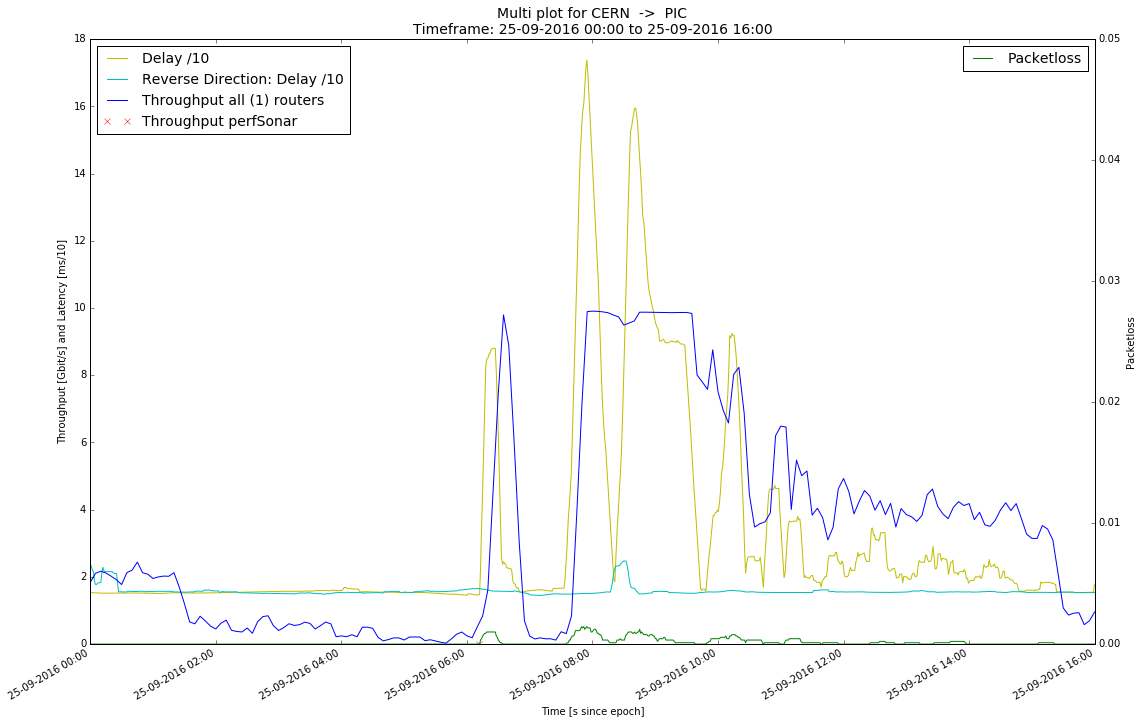

In [8]:
# configuration
src = "CERN"
dest = "PIC"
direction = "out"
timeframe = ['25-09-2016 00:00', '25-09-2016 16:00']
savePath = ''
#savePath = 'plots/router_multi_plots_2016-09-26/'

makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=savePath)

### Produce all possible plots given a certain timeframe 

In [3]:
timeframe = ['11-09-2016 16:00', '25-09-2016 16:00']
savePath = ''
#savePath = 'plots/router_multi_plots_2016-09-26_all-connections/'

makeAllPlots(timeframe, savePath=savePath)